In [18]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import rft_reconstruct_traj as rft

In [3]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf,frameRate = frameRate)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('/bucket/StephensU/antonio/ForagingN2_data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

In [5]:
n_clusters=1000
f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [6]:
f = h5py.File('../data/embedding_analysis/partition_combined_results_perworm.h5','r')
K_range = np.array(f['K_range'],dtype=int)
seed_range = np.array(f['seed_range'],dtype=int)
prob_K_s = np.array(f['probs'])
H_K_s = np.array(f['entropies'])
h_K_s = np.array(f['entropy_rates'])
Ipred_K_s = np.array(f['Ipreds'])
eps_K_s = np.array(f['eps_scale'])
f.close()

In [7]:
def std_bootstrap(l,n_times): 
    new_means = []
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    std = ma.std(new_means,axis=0)
    return ma.mean(l,axis=0),std

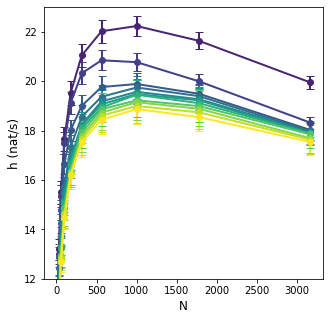

In [8]:
plt.figure(figsize=(5,5))
colors_K = plt.cm.viridis(np.linspace(.1,1,len(K_range[:22][::2])))
for k,K in enumerate(K_range[:22][::2]):
    mean,std = std_bootstrap(h_K_s[K-1,:13,:].T/dt,n_times=100)
    plt.errorbar(seed_range[:13],mean,std,c=colors_K[k],capsize=4,marker='o',lw=2)
plt.ylim(12,23)
plt.xlabel('N',fontsize=12)
plt.ylabel('h (nat/s)',fontsize=12)
# plt.savefig('h_N_Foraging_2K_N13.pdf')
plt.show()

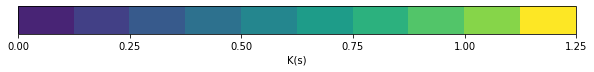

In [9]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_K)
cmap.set_over('0.1')
cmap.set_under('1.0')

bounds =  (K_range[:22][::2]-1)*dt
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.arange(0,1.6,.25),
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('K(s)')
# plt.savefig('colorbar_K_range_h_2K.pdf')
fig.show()


In [10]:
kN=10
h_K = h_K_s[:,kN,:]/dt

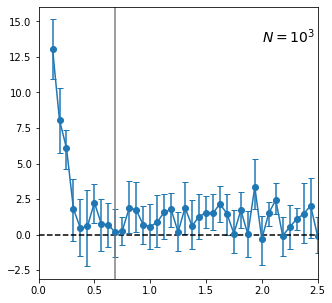

In [11]:
mean,cil,ciu = stats.bootstrap((-np.diff(h_K,axis=0).T/np.diff(K_range*dt)),n_times=1000)
plt.figure(figsize=(5,5))
plt.errorbar(K_range[1:-1]*dt,mean[1:],yerr = [mean[1:]-cil[1:],ciu[1:]-mean[1:]],capsize=3,marker='o')
plt.axhline(0,ls='--',c='k')
plt.axvline(0.6875,c='gray')
plt.xlim(0,2.5)
plt.text(2,13.5,'$N=10^3$',fontsize=14)
# plt.savefig('h_diff_Foraging_N_1000.pdf')
plt.show()

In [12]:
n_neighbors=50;min_dist=.05
f = h5py.File('../data/umap_embeddings/umap_n_{:.1f}_d_{:.2f}.h5'.format(n_neighbors,min_dist),'r')
u_all = ma.masked_invalid(f['umap'])
u_all[u_all==0] = ma.masked
f.close()
u = u_all[:-1000]
f.close()

In [13]:
t_fwd = 255141
t_dorsal = 168710
t_rev = 204380
t_ventral = 42865

In [15]:
# from matplotlib.colors import TwoSlopeNorm,LinearSegmentedColormap
from matplotlib.colors import DivergingNorm,LinearSegmentedColormap

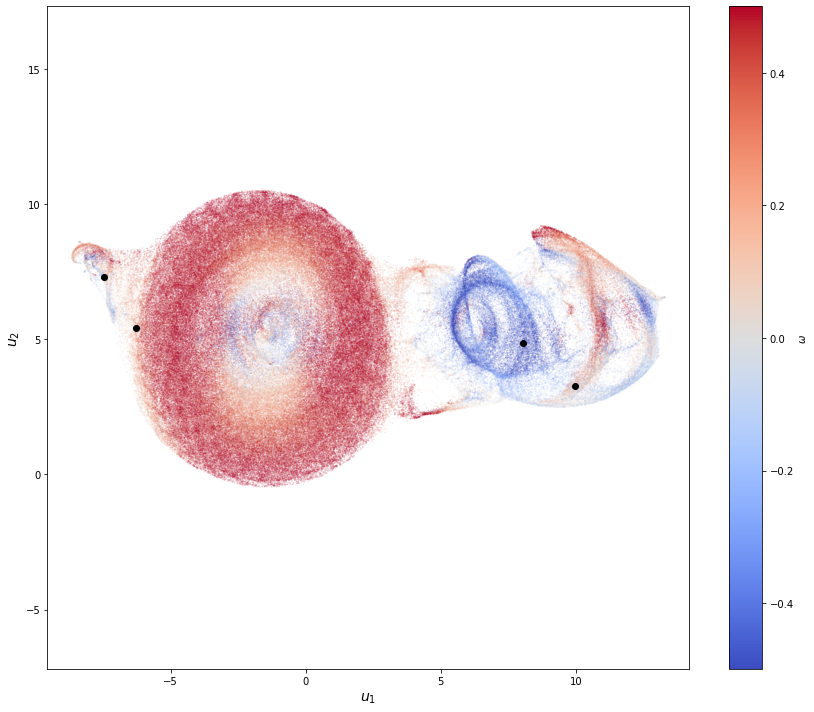

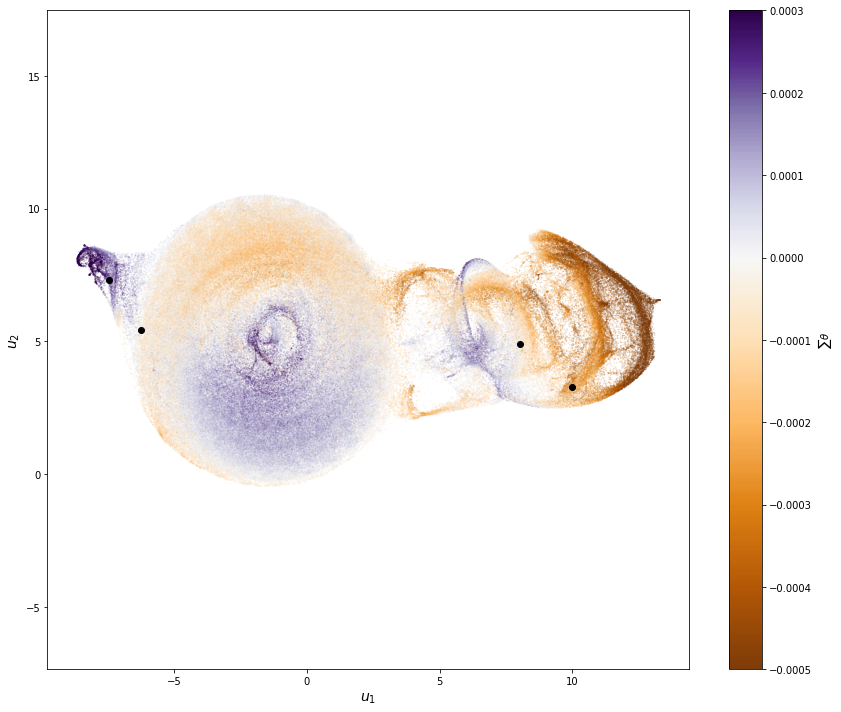

In [27]:
plt.figure(figsize=(12,10))
vmin,vmax=-.5,.5
sel = ~omegas_all.mask
plt.scatter(u[sel,0],u[sel,1],s=.003,norm=DivergingNorm(0,vmin=vmin,vmax=vmax),c=omegas_all[sel],cmap='coolwarm')
plt.colorbar(label='$\omega$')
plt.axis('equal')
plt.xlabel('$u_1$',fontsize=14)
plt.ylabel('$u_2$',fontsize=14)
plt.scatter(u[t_fwd,0],u[t_fwd,1],c='k')
plt.scatter(u[t_dorsal,0],u[t_dorsal,1],c='k')
plt.scatter(u[t_rev,0],u[t_rev,1],c='k')
plt.scatter(u[t_ventral,0],u[t_ventral,1],c='k')
plt.tight_layout()
# plt.savefig('umap_omegas_scatter.png',dpi=300)
plt.show()

sel = ~thetas_sum.mask
vmin,vmax=-5e-4,3e-4
plt.figure(figsize=(12,10))
plt.scatter(u[sel,0],u[sel,1],s=.01,norm=DivergingNorm(0,vmin=vmin,vmax=vmax),c=thetas_sum[sel],cmap='PuOr')
plt.colorbar(label=r'$\sum\theta$')
plt.axis('equal')
plt.xlabel('$u_1$',fontsize=14)
plt.ylabel('$u_2$',fontsize=14)
plt.tight_layout()

plt.scatter(u[t_fwd,0],u[t_fwd,1],c='k')
plt.scatter(u[t_dorsal,0],u[t_dorsal,1],c='k')
plt.scatter(u[t_rev,0],u[t_rev,1],c='k')
plt.scatter(u[t_ventral,0],u[t_ventral,1],c='k')
plt.tight_layout()
# plt.savefig('umap_theta_sum_scatter.png',dpi=300)
plt.show()

In [20]:
K_star=10
ts_rev = ma.vstack(tseries_w)[t_rev:t_rev+K_star]
ts_fwd = ma.vstack(tseries_w)[t_fwd:t_fwd+K_star]
ts_dorsal = ma.vstack(tseries_w)[t_dorsal:t_dorsal+K_star]
ts_ventral = ma.vstack(tseries_w)[t_ventral:t_ventral+K_star]


In [21]:
def reconstruct_traj(ts,eigenworms_matrix,alpha=1000.):
    angleArray = ts.dot(eigenworms_matrix[:,:5].T)
    theta = -angleArray.T
    L=1
    ds = L/(theta.shape[0])
    skel = rft.get_skels(theta,L)
    X = skel[:,:,0]
    Y = skel[:,:,1]
    XCM, YCM, UX, UY, UXCM, UYCM, TX, TY, NX, NY, I, OMEG = rft.get_RBM(skel,L,ds,dt)
    DX, DY, ODX, ODY, VX, VY, Xtil, Ytil, THETA = rft.subtractRBM(X, Y, XCM, YCM, UX, UY, UXCM, UYCM, OMEG, dt)
    TX,TY = rft.lab2body(TX, TY, THETA)
    VX,VY = rft.lab2body(VX, VY, THETA)
    RBM = rft.posture2RBM(TX,TY,Xtil,Ytil,VX,VY,L,I,ds,alpha)
    XCM_recon,YCM_recon,THETA_recon = rft.integrateRBM(RBM,dt,THETA)
    Xskel_recon,Yskel_recon =  rft.addRBMRotMat(Xtil, Ytil, XCM_recon, YCM_recon,THETA_recon, XCM, YCM, THETA)
    return Xskel_recon,Yskel_recon

In [22]:
alpha=1000.
Xskel_recon,Yskel_recon=reconstruct_traj(ts_rev,eigenworms_matrix)

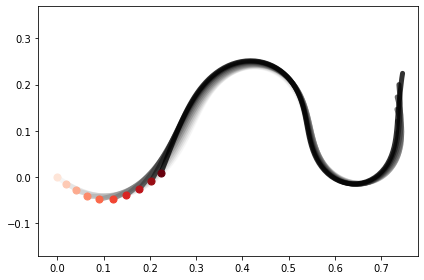

In [23]:
colors_t = plt.cm.Greys(np.linspace(0.1,1,len(ts_rev)))
colors_head = plt.cm.Reds(np.linspace(0.1,1,len(ts_rev)))

for kt in range(len(Xskel_recon)):
    plt.plot(np.array(Xskel_recon)[kt],np.array(Yskel_recon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xskel_recon)[kt][0],np.array(Yskel_recon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xskel_recon)+1)
plt.axis('equal')
plt.tight_layout()
# plt.savefig('rev_traj.pdf')
plt.show()

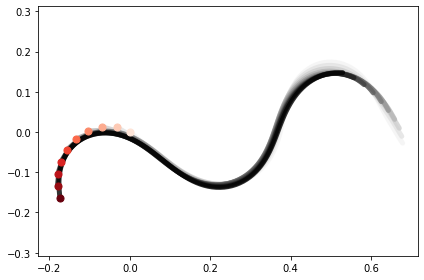

In [24]:
Xrecon,Yrecon=reconstruct_traj(ts_fwd,eigenworms_matrix)
colors_t = plt.cm.Greys(np.linspace(0.1,1,len(ts_fwd)))
colors_head = plt.cm.Reds(np.linspace(0.1,1,len(ts_fwd)))

for kt in range(len(Xrecon)):
    plt.plot(np.array(Xrecon)[kt],np.array(Yrecon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xrecon)[kt][0],np.array(Yrecon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xrecon)+1)
plt.axis('equal')
plt.tight_layout()
# plt.savefig('fwd_traj.pdf')
plt.show()

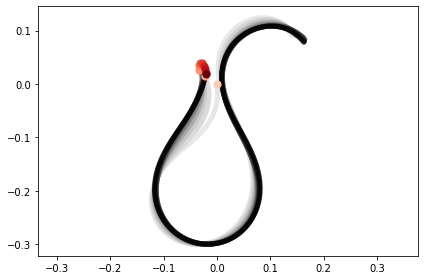

In [25]:
Xrecon,Yrecon=reconstruct_traj(ts_dorsal,eigenworms_matrix)
colors_t = plt.cm.Greys(np.linspace(0.2,1,len(ts_dorsal)))
colors_head = plt.cm.Reds(np.linspace(0.2,1,len(ts_dorsal)))

for kt in range(len(Xrecon)):
    plt.plot(np.array(Xrecon)[kt],np.array(Yrecon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xrecon)[kt][0],np.array(Yrecon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xrecon)+1)
plt.axis('equal')
plt.tight_layout()
# plt.savefig('dorsal_traj.pdf')
plt.show()


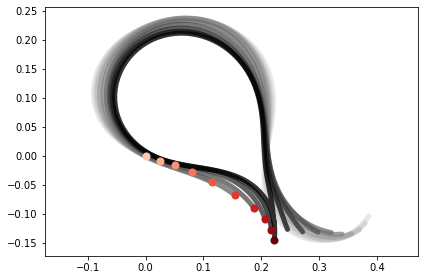

In [26]:
Xrecon,Yrecon=reconstruct_traj(ts_ventral,eigenworms_matrix)
colors_t = plt.cm.Greys(np.linspace(0.2,1,len(ts_ventral)))
colors_head = plt.cm.Reds(np.linspace(0.2,1,len(ts_ventral)))
for kt in range(len(Xrecon)):
    plt.plot(np.array(Xrecon)[kt],np.array(Yrecon)[kt],c=colors_t[kt],lw=5,alpha=.8,solid_capstyle='round')
    plt.scatter(np.array(Xrecon)[kt][0],np.array(Yrecon)[kt][0],color=colors_head[kt],s=50,zorder = len(Xrecon)+1)
plt.axis('equal')
plt.tight_layout()
# plt.savefig('ventral_traj.pdf')
plt.show()
